In [1]:
import pandas as pd
data_less_null = pd.read_csv('compounds_with_safety_processed.csv')

In [2]:
compound_list = [
    "andarine", "AZD2461", "BMS-906024", "candesartan", "CPI-0610", "cycloheximide",
    "dienogest", "epinastine", "evodiamine", "hypericin", "I-BRD9", "ilaprazole",
    "indiplon", "INT-767", "ITX3", "K-strophanthidin", "L-701324", "LY2183240",
    "MK-1064", "monensin", "narasin", "navarixin", "obeticholic-acid",
    "olmesartan-medoxomil", "palmatine-chloride", "perfluorodecalin",
    "PF-04217903", "PF-477736", "PIK-293", "resmetirom", "RU-28318",
    "sanguinarium-chloride", "SCH-58261", "SP-100030", "SPP86", "sulfinpyrazone",
    "sulindac", "TAK-063", "TC-S-7009", "TEPP-46", "tivantinib"
]

data_less_null['high_potential'] = data_less_null['compound_name'].isin(compound_list).astype(int)

# See if gpu is faster

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
import time
import xgboost as xgb

# Generate an even larger dataset
np.random.seed(42)
X = np.random.rand(1000000, 100)
y = np.random.rand(1000000)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data: standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
params_gpu = {
    'tree_method': 'hist',
    'device': 'cuda',
}

dtrain_gpu = xgb.DMatrix(X_train_scaled, label=y_train)
dtest_gpu = xgb.DMatrix(X_test_scaled, label=y_test)

# Training time on GPU
start_time = time.time()
model_gpu = xgb.train(params_gpu, dtrain_gpu, num_boost_round=2000)
gpu_train_time = time.time() - start_time

# Prediction time on GPU
start_time = time.time()
train_pred_gpu = model_gpu.predict(dtrain_gpu)
test_pred_gpu = model_gpu.predict(dtest_gpu)
gpu_pred_time = time.time() - start_time

# Evaluation
train_mae_gpu = mean_absolute_error(y_train, train_pred_gpu)
test_mae_gpu = mean_absolute_error(y_test, test_pred_gpu)
train_rmse_gpu = root_mean_squared_error(y_train, train_pred_gpu)
test_rmse_gpu = root_mean_squared_error(y_test, test_pred_gpu)

print(f"{'Training Time':<20}: {gpu_train_time:.4f} seconds")
print(f"{'Prediction Time':<20}: {gpu_pred_time:.4f} seconds")
print(f"Train MAE: {train_mae_gpu}, Test MAE: {test_mae_gpu}")
print(f"Train RMSE: {train_rmse_gpu}, Test RMSE: {test_rmse_gpu}")

Training Time       : 24.6547 seconds
Prediction Time     : 3.2670 seconds
Train MAE: 0.1623476666851024, Test MAE: 0.2588345493479747
Train RMSE: 0.19413181357115813, Test RMSE: 0.3034374496334633


In [13]:
from xgboost import XGBRegressor
model_cpu = XGBRegressor(n_estimators=2000)

# Training time on CPU
start_time = time.time()
model_cpu.fit(X_train_scaled, y_train)
cpu_train_time = time.time() - start_time

# Prediction time on CPU
start_time = time.time()
train_pred_cpu = model_cpu.predict(X_train_scaled)
test_pred_cpu = model_cpu.predict(X_test_scaled)
cpu_pred_time = time.time() - start_time

# Evaluation
train_mae_cpu = mean_absolute_error(y_train, train_pred_cpu)
test_mae_cpu = mean_absolute_error(y_test, test_pred_cpu)
train_rmse_cpu = root_mean_squared_error(y_train, train_pred_cpu)
test_rmse_cpu = root_mean_squared_error(y_test, test_pred_cpu)

print(f"{'Training Time':<20}: {cpu_train_time:.4f} seconds")
print(f"{'Prediction Time':<20}: {cpu_pred_time:.4f} seconds")
print(f"Train MAE: {train_mae_cpu}, Test MAE: {test_mae_cpu}")
print(f"Train RMSE: {train_rmse_cpu}, Test RMSE: {test_rmse_cpu}")

Training Time       : 41.1951 seconds
Prediction Time     : 2.3022 seconds
Train MAE: 0.16218858565827893, Test MAE: 0.2587251310271156
Train RMSE: 0.19389904189518398, Test RMSE: 0.3034189771369518


# basic xgboost model

In [6]:
from sklearn.impute import KNNImputer
clinical_phase = data_less_null['clinical_phase']
data_numerical = data_less_null.select_dtypes(include=['float64', 'int64'])
data_numerical['clinical_phase'] = clinical_phase
data_numerical = pd.get_dummies(data_numerical, columns=['clinical_phase'], drop_first=True)
imputer = KNNImputer(n_neighbors=15)
data_numerical = pd.DataFrame(imputer.fit_transform(data_numerical), columns=data_numerical.columns)

X = data_numerical.drop(columns=['high_potential'])
y = data_numerical['high_potential']

Original class distribution:
high_potential
0.0    6332
1.0      41
Name: count, dtype: int64
------------------------------
Features in X (all numerical, imputed, with clinical_phase encoded): ['cf_max_score', 'cf_avg_score', 'cf_top_pose', 'docking_max_score', 'docking_avg_score']... (57 total)
------------------------------

Performing Randomized Search for Hyperparameter Tuning (XGBoost on GPU)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

RandomizedSearchCV Results (XGBoost GPU):
Best Parameters found:  {'smote__k_neighbors': 2, 'smote__sampling_strategy': 0.25, 'xgb_classifier__colsample_bytree': np.float64(0.8170578538830306), 'xgb_classifier__gamma': np.float64(0.05730825042565688), 'xgb_classifier__learning_rate': np.float64(0.18724997817070324), 'xgb_classifier__max_depth': 8, 'xgb_classifier__n_estimators': 504, 'xgb_classifier__reg_alpha': np.float64(0.13734818874921442), 'xgb_classifier__reg_lambda': np.float64(0.9226005606596582), 'xgb_classifier__subs

C:\Users\luot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:729: UserWarning: [10:05:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Classification Report (Fold 1):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1267
         1.0       1.00      0.88      0.93         8

    accuracy                           1.00      1275
   macro avg       1.00      0.94      0.97      1275
weighted avg       1.00      1.00      1.00      1275

Confusion Matrix (Fold 1):
[[1267    0]
 [   1    7]]
AUC-ROC (Fold 1): 0.9986

--- Best XGBoost Model Fold 2/5 ---
Classification Report (Fold 2):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1267
         1.0       1.00      0.88      0.93         8

    accuracy                           1.00      1275
   macro avg       1.00      0.94      0.97      1275
weighted avg       1.00      1.00      1.00      1275

Confusion Matrix (Fold 2):
[[1267    0]
 [   1    7]]
AUC-ROC (Fold 2): 0.9993

--- Best XGBoost Model Fold 3/5 ---
Classification Report (Fold 3):
              prec

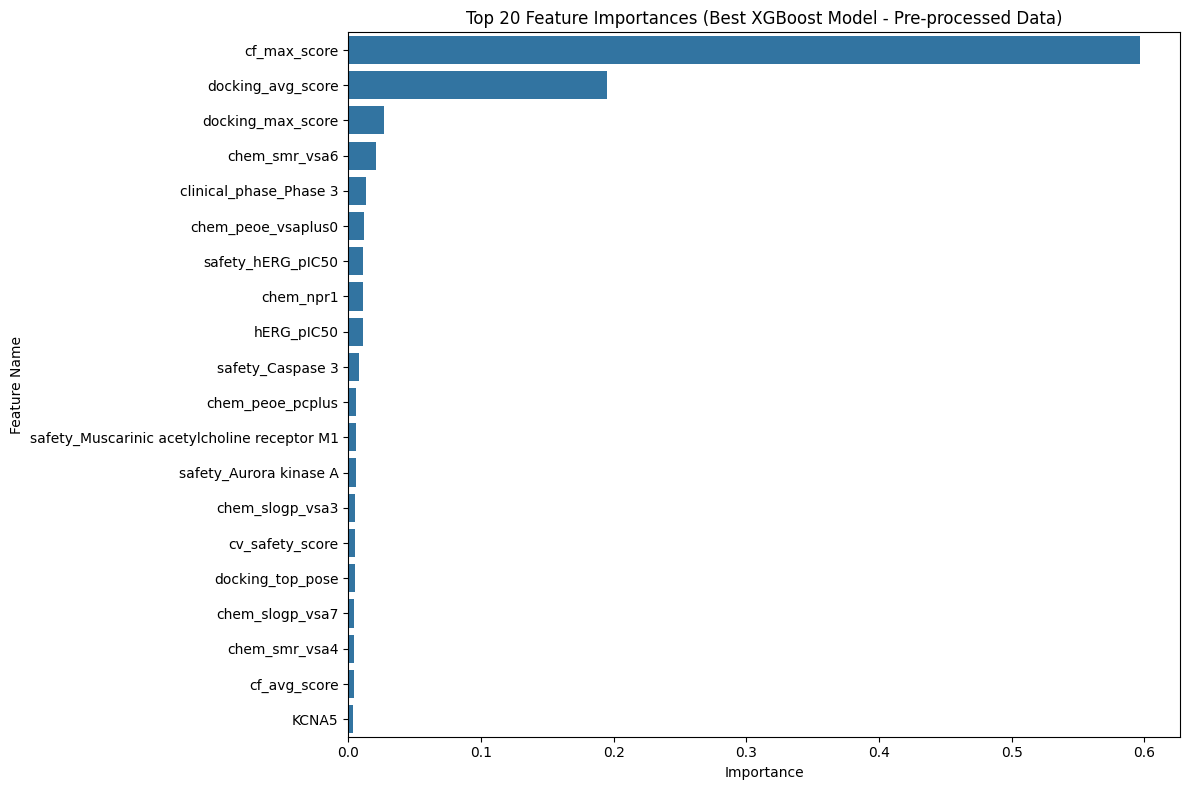

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns




print("Original class distribution:")
print(y.value_counts())
print("-" * 30)

# The numerical_cols here are simply all columns in X, as it's already pre-processed
numerical_cols = X.columns.tolist()

print(f"Features in X (all numerical, imputed, with clinical_phase encoded): {numerical_cols[:5]}... ({len(numerical_cols)} total)")
print("-" * 30)

# --- 3. Define the Pipeline (using XGBoost with GPU) ---
pipeline_xgb_gpu = Pipeline([
    ('scaler', StandardScaler()), # Scale numerical features (runs on CPU)
    ('smote', SMOTE(random_state=42)), # Oversample minority class (SMOTE typically runs on CPU)
    ('xgb_classifier', xgb.XGBClassifier(
        objective='binary:logistic', # For binary classification
        eval_metric='logloss',       # Evaluation metric during boosting
        tree_method='hist',          # Use histogram-based tree, required for GPU
        device='cuda',               # <--- THIS ENABLES GPU USAGE
        random_state=42,
        # Default scale_pos_weight for initial instantiation, will be tuned or overridden.
        # This parameter is crucial for imbalanced data in XGBoost.
        scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1])
    ))
])

# --- 4. Define the Parameter Grid for RandomizedSearchCV (tuned for XGBoost) ---
param_distributions_xgb = {
    # SMOTE parameters
    'smote__k_neighbors': randint(2, 10),
    'smote__sampling_strategy': [0.1, 0.25, 0.5, 0.75, 1.0, 'not majority'],

    # XGBoost Classifier parameters (note the 'xgb_classifier__' prefix)
    'xgb_classifier__n_estimators': randint(200, 1000), # Number of boosting rounds
    'xgb_classifier__learning_rate': uniform(0.01, 0.3), # Step size shrinkage
    'xgb_classifier__max_depth': randint(3, 10), # Max depth of individual trees (often shallower than RF)
    'xgb_classifier__subsample': uniform(0.6, 0.4), # Subsample ratio of the training instance (0.6 to 1.0)
    'xgb_classifier__colsample_bytree': uniform(0.6, 0.4), # Subsample ratio of columns (0.6 to 1.0)
    'xgb_classifier__gamma': uniform(0, 0.2), # Min loss reduction required to make a further partition
    'xgb_classifier__reg_lambda': uniform(0.1, 1.0), # L2 regularization term on weights (XGBoost uses reg_lambda)
    'xgb_classifier__reg_alpha': uniform(0.1, 1.0), # L1 regularization term on weights (XGBoost uses reg_alpha)
    # Note: scale_pos_weight is often fixed as a ratio of majority to minority,
    # but you could include it in the search if you wanted to test alternatives to the calculated ratio.
}


# --- 5. Set up Cross-Validation ---
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define a custom scorer for F1-score of the minority class (class 1)
f1_scorer_minority = make_scorer(f1_score, pos_label=1, zero_division=0)

# --- 6. Perform RandomizedSearchCV ---
print("\nPerforming Randomized Search for Hyperparameter Tuning (XGBoost on GPU)...")
random_search_xgb = RandomizedSearchCV(
    pipeline_xgb_gpu, # Use the new XGBoost pipeline
    param_distributions=param_distributions_xgb, # Use the new XGBoost param grid
    n_iter=50, # Number of parameter settings sampled. Adjust based on computational budget.
    cv=skf,
    scoring=f1_scorer_minority, # Optimize for F1-score of minority class
    verbose=2,
    random_state=42,
    n_jobs=-1 # Use all available CPU cores for the search (XGBoost itself uses GPU)
)

# Fit RandomizedSearchCV on your already prepared X and y
random_search_xgb.fit(X, y)

print("\n" + "=" * 50)
print("RandomizedSearchCV Results (XGBoost GPU):")
print("Best Parameters found: ", random_search_xgb.best_params_)
print("Best F1-Score (Minority Class) found: {:.4f}".format(random_search_xgb.best_score_))
print("=" * 50)

# --- 7. Final Model Evaluation with Best Estimator ---
print("\nEvaluating the best XGBoost model from RandomizedSearchCV using cross-validation...")
best_pipeline_xgb = random_search_xgb.best_estimator_

all_y_true_best_xgb = []
all_y_pred_best_xgb = []
all_y_proba_best_xgb = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"\n--- Best XGBoost Model Fold {fold+1}/{n_splits} ---")
    best_pipeline_xgb.fit(X_train, y_train)
    y_pred = best_pipeline_xgb.predict(X_test)
    y_proba = best_pipeline_xgb.predict_proba(X_test)[:, 1]

    all_y_true_best_xgb.extend(y_test)
    all_y_pred_best_xgb.extend(y_pred)
    all_y_proba_best_xgb.extend(y_proba)

    print("Classification Report (Fold {}):".format(fold+1))
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix (Fold {}):".format(fold+1))
    print(confusion_matrix(y_test, y_pred))
    try:
        auc_roc = roc_auc_score(y_test, y_proba)
        print("AUC-ROC (Fold {}): {:.4f}".format(fold+1, auc_roc))
    except ValueError:
        pass

print("\n" + "=" * 50)
print("Overall Performance of Best XGBoost Model from RandomizedSearchCV:")
print(classification_report(all_y_true_best_xgb, all_y_pred_best_xgb, zero_division=0))
print("Confusion Matrix (Overall):")
print(confusion_matrix(all_y_true_best_xgb, all_y_pred_best_xgb))
print("Overall Accuracy: {:.4f}".format(accuracy_score(all_y_true_best_xgb, all_y_pred_best_xgb)))
try:
    overall_auc_roc_best_xgb = roc_auc_score(all_y_true_best_xgb, all_y_proba_best_xgb)
    print("Overall AUC-ROC: {:.4f}".format(overall_auc_roc_best_xgb))
except ValueError:
    pass
overall_f1_minority_best_xgb = f1_score(all_y_true_best_xgb, all_y_pred_best_xgb, pos_label=1, zero_division=0)
print(f"Overall F1-Score (Minority Class 1): {overall_f1_minority_best_xgb:.4f}")
print("=" * 50)


# --- 8. Feature Importance for the Best XGBoost Model ---
print("\n" + "=" * 50)
print("Extracting Feature Importances for the Best XGBoost Model...")

best_pipeline_xgb.fit(X, y) # Ensure the pipeline is fit on the full X

xgb_model_best = best_pipeline_xgb.named_steps['xgb_classifier']
importances = xgb_model_best.feature_importances_ # XGBoost has feature_importances_

feature_importance_df_best_xgb = pd.DataFrame({
    'Feature': numerical_cols, # Feature names are simply the columns of X
    'Importance': importances
})

feature_importance_df_best_xgb = feature_importance_df_best_xgb.sort_values(by='Importance', ascending=False)

print("\nTop 20 Feature Importances (Best XGBoost Model):")
print(feature_importance_df_best_xgb.head(20))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_best_xgb.head(20))
plt.title('Top 20 Feature Importances (Best XGBoost Model - Pre-processed Data)')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()